In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
sys.path.append('C:/Users/Fabian/gempy')
#sys.path.insert(1,'/home/fabian/gempy')
import gempy as gp

In [ ]:
%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

#import vtk
#import evtk

from scipy.interpolate import griddata

In [ ]:
import gempy.utils.spill_analysis as sp
import gempy.utils.fault_analysis as fa
import gempy.utils.decision_making as dm

In [ ]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = "./input_data/orientations.csv",
                        path_i = "./input_data/surface_points.csv")
geo_data.n_faults = 1

In [ ]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

In [ ]:
figsize(20,10)
#plt.savefig('points.pdf', transparent=True)
gp.plotting.plot_data(geo_data, direction='x')

In [ ]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
def set_fault_sides(geo_data, fault_border, fault_name):
    geo_data.interfaces['fault side'] = 'nan'
    HW_border = fault_border # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    nonfault_cond = geo_data.interfaces['formation'] != fault_name
    fault_cond = geo_data.interfaces['formation'] == fault_name

    fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

    hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

    geo_data.interfaces.loc[fw_x_cond,'fault side'] = 'footwall' # setting FW
    geo_data.interfaces.loc[hw_x_cond,'fault side'] = 'hanging wall' #setting HW
    geo_data.interfaces.loc[fault_cond,'fault side'] = 'nan'; # reverting fault points to 'nan'
    return geo_data

In [ ]:
geo_data = set_fault_sides(geo_data, 1300, 'MainFault')

In [ ]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients',
                                 compile_theano=True, dtype ='float64', theano_optimizer='fast_run')

In [ ]:
#interp_data.interpolator.tg.inf_factor.set_value(np.zeros(7, dtype='int32'))
#interp_data.interpolator.tg.inf_factor.get_value()

In [ ]:
import pandas as pd

In [ ]:

# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [ ]:
gp.plotting.plot_section(geo_data, lith_sol[0], 25, plot_data=True)

In [ ]:
# Geo formation numbers
base_n = geo_data.formations.loc['basement','formation_number']
res_n = geo_data.formations.loc['Base_Top','formation_number']
seal_n = geo_data.formations.loc['Res_Top','formation_number']
secres_n = geo_data.formations.loc['Seal_Top','formation_number']
over_n = geo_data.formations.loc['SecRes_Top','formation_number']
fault_n = geo_data.formations.loc['MainFault','formation_number']

In [ ]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                         potential_fault=None, n_formation = res_n-1)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = seal_n-1)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                               potential_fault=None, n_formation = secres_n-1)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = over_n-1)

fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = 
                                             interp_data, potential_lith=None, potential_fault=fault_sol[1], 
                                             n_formation = fault_n-1)

In [ ]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [ ]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 4

permeable_l = [secres_n, over_n]

In [ ]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

In [ ]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
#gp.plotting.plot_section(geo_data, lith_block, int(resolution/2), plot_data=1, direction='y')
#plt.savefig('computed_block.pdf', transparent=True)

In [ ]:
GX,GY,GZ=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution), lith_sol[4].reshape(resolution,resolution,resolution)

In [ ]:
round((1000/scale_factor)+0.5).astype(int)

In [ ]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith, fault, bottom_z, formation_bool, fault_bool, tc):
    mask = np.ones_like(lith)
    mask[~formation_bool] = False
    mask[fault_bool] = False
    #mask[fault.astype(bool)] = False
    if tc == 1:
        bottom_z = round((bottom_z/scale_factor)+0.5).astype(int) #rounding up to avoid voxel connection to outside borders
    else:
        bottom_z = round((bottom_z/scale_factor)).astype(int)
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(geo_data, lith, fault, seal_th, trap_n):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
        gp.topology.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 0)
    trap_keys = [int(k) for k in lith_to_labels_lot["%s" % trap_n].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["0"].keys()] # model border sections
    base_keys = [int(b) for b in lith_to_labels_lot["%s" % base_n].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_n].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_n].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_n].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    #gp.topology.classify_edges(G, centroids, lith.reshape(resolution,resolution,resolution), fault.reshape(resolution,resolution,resolution))   
    gp.topology.classify_edges(G, centroids, lith_pad, fault_pad)   
    # If too many traps, model probably broken:
    print("NUMBER OF POTENTIAL TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        print('Too many traps detected. Reservoir discontinuous or model probably broken.')
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology.check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                traps.append(tk)
                print('TRAP CONFIRMED:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask # this mask returns True for all voxels which were accepted as trap voxels

In [ ]:
# get juxtaposition with itself
def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n):
    hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
    maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
    if np.any(maxline_hw):
        max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z
        return max_jux
    else:
        return 0

#def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
#                        res_n):
#    juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
#                        lith_target=res_n, lith_jux=res_n, target_side='fw', projection='automatic')
#    if np.any(juxta):
#        max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
#        return max_jux
#    else:
#        return 0

In [ ]:
#hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
#maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
#if np.any(maxline_hw):
#    max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z

In [ ]:
# get juxtapositions with any other input perm layers
def perm_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, lith_perm):
    if isinstance(lith_perm, int):
        lith_perm = [lith_perm]
    juxta_list = np.zeros((len(lith_perm),2))
    juxta_list[:,0] = np.array(lith_perm)
    for i in lith_perm:
        juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, i, target_side='fw', projection='automatic')
        if np.any(juxta):
            max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
            juxta_list[(np.argwhere(juxta_list[:,0]==i)),1] = max_jux
    juxta_list = np.delete(juxta_list, np.argwhere(juxta_list[:,1]==0), 0)
    return juxta_list        

In [ ]:
# get SSF on base of fault analysis module
def fa_SSF(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position='faultmax_argrelmax', order=40):
    fault_throws = fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position=position, order=order, artifact_filter='on')
    max_throw = np.nanmax(fault_throws)
    contact = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw')
    proj = fa.project_voxels(contact, form='2D')
    lith_thickness = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw',
                      position=position, order=order, artifact_filter='on')
    min_thickness = np.nanmin(lith_thickness)
    SSF = max_throw/min_thickness
    print('SSF = %s / %s = %s' % (max_throw, min_thickness, SSF))
    return SSF

In [ ]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps
def max_trap_vol(geo_data, interp_data, lith_sol, fault_sol, res_n, seal_n, fault_n, GX, GY, seal_surf_v):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    trap_n = (np.max(formation_numbers)+1)
    
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]
    
    seal_thickness_all = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, 
                                                 seal_n, fault_n, fault_side='fw',
                      position='faultmax_argrelmax', order=40)
    seal_thickness = np.nanmin(seal_thickness_all)
    
    seal_thresh = vox_size_z
    if seal_thickness < seal_thresh:
        print("Seal layer compromised, too thin.")
        print('CONTROL: STRAT. SEAL BREACH')
        # Trap failed due to assumed seal cap discontinuity: return no volume, no trap, SSF = nan
        return 0, np.zeros_like(lith_block), np.nan, 4    

    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage 
    highest_spill_point = sp.get_highest_saddle_point(geo_data, seal_surf_v, GX, GY)
    
    if highest_spill_point == []:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith_block)
        return trap_vol, final_trap_mask, np.nan, 0
    
    spill_z = np.max(highest_spill_point[2])
    leak_self_z = self_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n)
    # need to implement variability of permeable layers
    juxta_above = perm_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n, lith_perm=permeable_l)
    
    print('SPILL POINT COORDINATES:', highest_spill_point)
    print('LEAK SELF Z-POSITION:', leak_self_z)
    print('JUXTA with permable layers:', juxta_above)

    SSF = fa_SSF(geo_data, lith_sol, fault_sol, seal_n, fault_n,
                      position='faultmax_argrelmax', order=40)
    if SSF > SSF_c:
        print('SSF threshold exceeded, shale smear assumed to be incomplete.')
        SSF_sealing = False
    else: 
        print('SSF in confidence range, complete shale smear sealing assumed.')
        SSF_sealing = True
        
    #general_sealing = False # might be implemented later (as binomial probability)
    
    if juxta_above.size == 0:
        leak_z = leak_self_z
        # no SSF necessary (but still have to be calculated if relevant in probabilistic model)
        # possible use of general fault sealing probability
        max_z = np.nanmax([spill_z, leak_z])  
        if max_z == spill_z:
            trap_control = 1
            print('CONTROL: SPILL Z')
        else:
            trap_control = 2
            print('CONTROL: LEAK Z')
    else:
        # check for SSF/general sealing
        if SSF_sealing == False: 
            leak_above_z = np.max(juxta_above[:,1])
            max_z = np.nanmax([spill_z, leak_above_z]) 
            if max_z == spill_z:
                trap_control = 1
                print('CONTROL: SPILL Z')
            else:
                trap_control = 3
                print('CONTROL: PERM. JUXTA Z')
        #elif general_sealing == False:
        #    max_z = np.nanmax([spill_z, leak_self_z])
        #    if max_z == spill_z:
        #        trap_control = 1
        #    else:
        #        trap_control = 2   
        else:
            max_z = spill_z
            trap_control = 1
            print('CONTROL: SPILL Z')
            
    ### MAKE AN OWN FUNCTION TO GET MAX_Z!              
        
    rounded_lith = np.around(lith_block).astype(int)
    rounded_fault = np.around(fault_block).astype(int)
    res_n_bool = rounded_lith == res_n
    fault_bool = rounded_lith == 2
        
    pre_trap_mask = res_mask(lith_block, fault_block, max_z, res_n_bool, fault_bool, tc = trap_control)
          
    # volume cells for counting
    vol_cells = 0
    lith_copy = np.copy(lith_block)
        
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        #trap_control = 0
        return 0, pre_trap_mask, SSF, trap_control
    else:
        lith_copy[pre_trap_mask_bool] = trap_n                           # setting reservoir above bottom on footwall side 
        final_trap_mask = topo_analysis(geo_data, lith_copy, fault_block, seal_thickness, trap_n)
        lith_copy[final_trap_mask] = (trap_n + 1)                        # setting final trap to formation value = trap_n + 1
        vol_cells = np.count_nonzero(final_trap_mask)
            
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        # revert to lith_block without any masks
        #lith[pre_trap_mask_bool] = res_n      
        #return the maximum reservoir volume
        return trap_vol, final_trap_mask, SSF, trap_control

In [ ]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

### Setting up the probabilistic model

In [ ]:
lith_unc_stds = np.array([40,60,80,100])
#lith_unc_stds = np.array([20,60,100,200])

In [ ]:
lith_ids = geo_data.interfaces["formation"].dropna().unique()[1:-1]
print(lith_ids)

In [ ]:
lith_numbers = geo_data.formations.formation_number[1:]

In [ ]:
lith_Z_modifier = []

for liID, stdi in zip(lith_ids, lith_unc_stds):
    stoch = pymc.Normal(liID+'_stoch', 0, 1./np.square(stdi/rescale_f))
    lith_Z_modifier.append(stoch)

In [ ]:
faultside_ids = geo_data.interfaces["fault side"].dropna().unique()
print(faultside_ids)

In [ ]:
std_offset = 150
fault_Z_modifier = pymc.SkewNormal(faultside_ids[1]+'offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

In [ ]:
# sample from a distribution
samples = [lith_Z_modifier[3].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Z modifier")
plt.vlines(0, 0, 0.01)
plt.ylabel("n");

In [ ]:
import copy
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)
#interp_data_stoch_init = copy.deepcopy(interp_data)

In [ ]:
# NEW INTERP FUNCTION
@pymc.deterministic(trace=True)
def input_data(value=0, geo_data_stoch_init=geo_data_stoch_init, lith_Z_modifier=lith_Z_modifier, 
              fault_Z_modifier=fault_Z_modifier, verbose= 0):
    
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    for e, foID in enumerate(lith_ids):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['formation'] == foID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(lith_Z_modifier[e])
        
    sel_fa = gp.get_data(interp_data.geo_data_res, verbosity=2)['fault side'] == 'hanging wall'
    geo_data_stoch.loc[sel_fa, 'Z']  += np.array(fault_Z_modifier)
    ''
    if verbose > 0:
        print(geo_data_stoch)
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [ ]:
@pymc.deterministic(trace=False)
def gempy_model(value=0, input_data=input_data, seal_n=seal_n, print_figures=False):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    try:
        # try to compute model
        ls, fs = gp.compute_model(interp_data)
        if print_figures:
            gp.plot_section(geo_data, ls[0], np.int(resolution/2), plot_data=False)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return ls, fs, interp_data
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_sol), np.zeros_like(fault_sol), interp_data

In [ ]:
@pymc.deterministic(trace=True)
def trap_analysis(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1], 
                  interp_data=gempy_model[2], print_figures=False, verbose = False):
    
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    try:
        max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
        return max_vol, SSF, trap_control
    
    except (IndexError, ValueError):
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose == True:
            print("Exception occured.")
        return np.nan, np.nan, 0
#@pymc.deterministic(trace=True)
#def trap_analysis(value=0, input_data=input_data, print_figures=False):
#    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
#    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
#                                           'dip', 'azimuth', 'polarity']] = input_data[1]
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)    
#    try:
#        # try to compute model
#        lith_sol, fault_sol = gp.compute_model(interp_data)
#        if print_figures:
#            gp.plot_section(interp_data.geo_data_res, lith_sol[0], np.int(resolution/2), plot_data=True)
#           # gp.plot_data(interp_data.geo_data_res, direction='y')
#    
#    except np.linalg.linalg.LinAlgError as err:
#        # if it fails (e.g. some input data combinations could lead to 
#        # a singular matrix and thus break the chain) return an empty model
#        # with same dimensions (just zeros)
#        if verbose:
#            print("Exception occured.")
#        return np.nan, np.nan, np.nan
#    
#    seal_surf_V = gp.get_surfaces(\
#        interp_data = interp_data, potential_lith=lith_sol[1], \
#        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
#    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
#    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
#                                                    lith_sol, fault_sol, res_n, 
#                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
#    print("Maximum trap volume: %s m³" % max_vol)
#    if print_figures:
#        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
#    return max_vol, SSF, trap_control

In [ ]:
def trap_analysis_post(lith_sol, fault_sol, print_figures=False):
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]  
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
    print("Maximum trap volume: %s m³" % max_vol)
    print('TRAP VOXELS:', np.count_nonzero(trap))
    if print_figures:
        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return max_vol, SSF, trap_control # trap --> what to do about trap return?

In [ ]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

In [ ]:
# Reservoir thickness
@pymc.deterministic(trace=True)
def thicknesses(value=0, input_data=input_data):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    res_th = np.abs(fw_sb_z-fw_rb_z)
    seal_th = np.abs(fw_r2b_z-fw_sb_z)
    secres_th = np.abs(fw_ob_z-fw_r2b_z) 
    return res_th, seal_th, secres_th

#Seal thickness
#@pymc.deterministic(trace=True)
#def seal_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_r2b_z-fw_sb_z)
#
## Secondary reservoir thickness
#@pymc.deterministic(trace=True)
#def sec_res_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_ob_z-fw_r2b_z) 

In [ ]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 10

#@pymc.stochastic()
#def sec_res_th_likelihood(value = 0, sec_res_th=thicknesses[2]):
#    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic()
def seal_th_likelihood(value = 0, seal_th=thicknesses[1]):
    return pymc.normal_like(seal_th, 300., 1./np.square(std2))

@pymc.stochastic()
def res_th_likelihood(value = 0, res_th=thicknesses[0]):
    return pymc.normal_like(res_th, 80., 1./np.square(std3))


## SSF LIKELIHOOD
#@pymc.stochastic()
#def SSF_likelihood(value = 0, SSF=trap_analysis[1]):
#    return pymc.normal_like(SSF, 5, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [ ]:
block = np.round(lith_sol[0]).astype(int)
block_fb = np.round(fault_sol[0]).astype(int)

lith_id = np.unique(np.round(block).astype(int))
fault_id = np.unique(np.round(block).astype(int))

count = np.zeros((len(lith_id), block.shape[0]))
count_fb = np.zeros((len(fault_id), block_fb.shape[0]))  

@pymc.deterministic(trace=True)
def lith_prob(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1]):
    block = np.round(lith_sol[0]).astype(int)
    block_fb = np.round(fault_sol[0]).astype(int)
    for i, l_id in enumerate(lith_id):
        count[i][block == l_id] += 1 #sum up frequency
    for i, f_id in enumerate(fault_id):
        count_fb[i][block_fb == f_id] += 1 #sum up frequency

In [ ]:
iterations = 11000

In [ ]:
#params = [input_data, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
#params = [input_data, seal_th_likelihood, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
params = [input_data, SSF_likelihood, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
#params = [input_data, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood, SSF_likelihood, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [1]:
dbname="Res80-10_Seal300-30"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"
#dbname='test_ssf.hdf5'

In [ ]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)
#RUN = pymc.MCMC(model)

In [ ]:
from pymc import AdaptiveMetropolis
RUN.use_step_method(AdaptiveMetropolis, params)

In [50]:
RUN.sample(iter=iterations, burn=1000)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          736.31706238]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 20992000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          736.31896973]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in or

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          736.31896973]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 21056000.0 m³
 [                  1%                  ] 2 of 200 complete in 16.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          736.29692078]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [                  1%                  ] 3 of 200 complete in 30.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          731.20452881]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 21
Maximum trap volume: 19328000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          731.22459412]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 19392000.0 m³
No maxima found for surface.
SPILL 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [                  2%                  ] 4 of 200 complete in 43.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          731.34773254]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 20032000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          731.34773254]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 20032000.0 m³
No maxima found for surface.
SPILL 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [                  2%                  ] 5 of 200 complete in 57.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          773.45619202]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 19584000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          773.45436096]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 19584000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1330.90911865  920.          760.        ]
LEAK SELF Z-POSIT

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-                 3%                  ] 6 of 200 complete in 70.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          759.08172607]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 29568000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          759.07356262]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 29568000.0 m³
No maxima found for surface.
SPILL 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-                 3%                  ] 7 of 200 complete in 83.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.55718994]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 22528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         869.5476532]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 22528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.78089905]
LEAK S

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-                 4%                  ] 8 of 200 complete in 97.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.84757996]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.84864807]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          886.253

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-                 4%                  ] 9 of 200 complete in 110.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.85307312]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.79325867]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 20992000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-                 5%                  ] 10 of 200 complete in 125.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.95240784]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 30
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.97727966]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         824.596

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--                5%                  ] 11 of 200 complete in 138.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         864.0397644]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.00901794]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          750.8574

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--                6%                  ] 12 of 200 complete in 152.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.03297424]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         864.0524292]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 20992000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         865.733413

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.03297424]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 21056000.0 m³
 [--                6%                  ] 13 of 200 complete in 171.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.03411865]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.0

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--                7%                  ] 14 of 200 complete in 184.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         864.0045166]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.02046204]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          712.8356

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--                7%                  ] 15 of 200 complete in 197.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          864.01473999]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         863.9932251]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          763.7075

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---               8%                  ] 16 of 200 complete in 211.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.97399902]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 20992000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.94920349]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 28
Maximum trap volume: 21056000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          780.7

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---               8%                  ] 17 of 200 complete in 224.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.93577576]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 20992000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.97514343]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 20992000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          780.4

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---               9%                  ] 18 of 200 complete in 238.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.93249512]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20928000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.89343262]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 20992000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.0

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---               9%                  ] 19 of 200 complete in 251.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.07069397]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20480000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.05154419]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20544000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          745.1

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.05154419]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20544000.0 m³
 [---              10%                  ] 20 of 200 complete in 267.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.05039978]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 20544000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.0

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---              10%                  ] 21 of 200 complete in 281.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         862.0173645]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 20544000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         862.0426178]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 20544000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         857.7255249]


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         857.7255249]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 19392000.0 m³
 [----             11%                  ] 22 of 200 complete in 297.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.72674561]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 19392000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.7019

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----             11%                  ] 23 of 200 complete in 310.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.68730164]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 19392000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.71995544]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 19328000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----             12%                  ] 24 of 200 complete in 324.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         857.7973175]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  920.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 27
Maximum trap volume: 19712000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         857.7922821]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  920.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 27
Maximum trap volume: 19712000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Max

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----             12%                  ] 25 of 200 complete in 336.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.72819519]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 32
Maximum trap volume: 19584000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.76893616]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 19520000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          891.05323792]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----             13%                  ] 26 of 200 complete in 348.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.77084351]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 34
Maximum trap volume: 19584000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.77900696]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 33
Maximum trap volume: 19648000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        876.717453]
LEAK SE

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        876.717453]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 25536000.0 m³
 [-----            13%                  ] 27 of 200 complete in 364.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.73225403]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 31
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.74514771]
LEAK SE

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----            14%                  ] 28 of 200 complete in 377.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.73828125]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 31
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.74354553]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          898.28536987]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----            14%                  ] 29 of 200 complete in 390.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.75552368]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         876.7641449]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          835.31013489]
LEAK

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----            15%                  ] 30 of 200 complete in 403.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.75010681]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 33
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.71211243]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 33
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          885.36827087]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----            15%                  ] 31 of 200 complete in 416.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.73751831]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 34
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.69372559]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.78121948]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------           16%                  ] 32 of 200 complete in 431.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.71928406]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 34
Maximum trap volume: 25472000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.73782349]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 34
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          905.35583496]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.73782349]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 34
Maximum trap volume: 25536000.0 m³
 [------           16%                  ] 33 of 200 complete in 446.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.73736572]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 35
Maximum trap volume: 25536000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         876.7326355]
LEAK

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------           17%                  ] 34 of 200 complete in 459.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1336.22375488  920.          880.        ]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 33
Maximum trap volume: 26688000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1332.75360107  920.          880.        ]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          816.26182556]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------           17%                  ] 35 of 200 complete in 475.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1336.40289307  920.          880.        ]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 33
Maximum trap volume: 26816000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1334.22225952  920.          880.        ]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1336.40289307  920.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------           18%                  ] 36 of 200 complete in 489.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1343.8848877  920.         880.       ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1345.53192139  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         743.625259

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------          18%                  ] 37 of 200 complete in 502.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1345.2482605  920.         880.       ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1346.85317993  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          918.1468

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------          19%                  ] 38 of 200 complete in 516.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1346.37680054  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1345.29418945  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26432000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          921.5

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------          19%                  ] 39 of 200 complete in 528.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1345.56396484  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1344.0625  920.      880.    ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 26560000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          697.42248535]
LEA

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------          20%                  ] 40 of 200 complete in 541.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1344.47753906  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 26560000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1346.47064209  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26432000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          770.9

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------          20%                  ] 41 of 200 complete in 555.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.65106201  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.94729614  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          952.97035217]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1120.]
 [ 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1347.65106201  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
 [-------          21%                  ] 42 of 200 complete in 572.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.73330688  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1349.5425415  920.         880.       ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF =

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------         21%                  ] 43 of 200 complete in 586.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.48306274  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.724823  920.        880.      ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1347.48306274  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------         22%                  ] 44 of 200 complete in 601.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.73330688  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.94729614  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          797.77023315]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SS

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1347.73330688  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
 [--------         22%                  ] 45 of 200 complete in 619.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.73330688  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.00003052  920.          880. 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1347.73330688  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
 [--------         23%                  ] 46 of 200 complete in 636.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.65106201  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.00003052  920.          880. 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1347.65106201  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
 [--------         23%                  ] 47 of 200 complete in 653.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.02697754  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.26660156  920.          880. 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------        24%                  ] 48 of 200 complete in 669.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.11410522  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1345.20553589  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1334.65118408  920.          840. 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------        24%                  ] 49 of 200 complete in 681.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1344.93499756  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 26560000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1342.40005493  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 26560000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          811.9

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------        25%                  ] 50 of 200 complete in 695.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1342.38998413  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1341.51901245  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 26560000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          918.8

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------        25%                  ] 51 of 200 complete in 707.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1340.74996948  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1340.74996948  920.          880.        ]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 26496000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.4

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------        26%                  ] 52 of 200 complete in 721.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.49653625]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.51156616]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 15488000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
N

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.51156616]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 15488000.0 m³
 [----------       26%                  ] 53 of 200 complete in 736.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.51217651]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         844.553

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       27%                  ] 54 of 200 complete in 751.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.54650879]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.56291199]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          884.6

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       27%                  ] 55 of 200 complete in 764.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.52537537]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.54689026]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       28%                  ] 56 of 200 complete in 780.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.54689026]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.55955505]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       28%                  ] 57 of 200 complete in 792.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.56016541]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 25
Maximum trap volume: 15616000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.56726074]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 15488000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------      29%                  ] 58 of 200 complete in 806.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         863.3039093]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 20672000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.31367493]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 20672000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------      29%                  ] 59 of 200 complete in 818.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.30207825]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 20608000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.31184387]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 20608000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          753.7

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------      30%                  ] 60 of 200 complete in 831.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.10966492]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 20288000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.10409546]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 20288000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         869.372

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------      30%                  ] 61 of 200 complete in 845.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.56573486]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 22592000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.57252502]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 22528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          821.5

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------      31%                  ] 62 of 200 complete in 858.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.46281433]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 22080000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.43153381]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 22208000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
N

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------      31%                  ] 63 of 200 complete in 870.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.20448303]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 22144000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         869.1709137]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 22208000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.  

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         869.1709137]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 22208000.0 m³
 [------------     32%                  ] 64 of 200 complete in 885.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.17480469]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 22272000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.  

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------------     32%                  ] 65 of 200 complete in 898.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.31266785]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 33
Maximum trap volume: 22528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          869.29649353]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 32
Maximum trap volume: 22592000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          870.18806458]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------------     33%                  ] 66 of 200 complete in 911.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          870.11726379]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 30
Maximum trap volume: 22784000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         870.0743866]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.44447327]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 104

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [------------     33%                  ] 67 of 200 complete in 923.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.43005371]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 21376000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.47193909]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 21376000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          742.74986267]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.47193909]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 21376000.0 m³
 [------------     34%                  ] 68 of 200 complete in 939.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.46995544]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 21312000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.49368286]
L

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------------    34%                  ] 69 of 200 complete in 952.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.57791138]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 21376000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.62399292]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          803.33145142]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SS

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------------    35%                  ] 70 of 200 complete in 967.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          866.59095764]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 21376000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         866.5725708]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 21376000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.8181

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.81814575]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 18880000.0 m³
 [-------------    35%                  ] 71 of 200 complete in 983.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.81387329]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 18880000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.7

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-------------    36%                  ] 72 of 200 complete in 996.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         884.2829895]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 14848000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          884.23370361]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  840.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 14848000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.  

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          884.23370361]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  840.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 14848000.0 m³
 [-------------    36%                  ] 73 of 200 complete in 1011.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          884.23713684]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 14848000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.47291565]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 23744000.0 m³
 [--------------   37%                  ] 74 of 200 complete in 1027.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.47909546]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 23744000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.52441406]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 23744000.0 m³
 [--------------   37%                  ] 75 of 200 complete in 1042.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.52120972]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 23744000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------------   38%                  ] 76 of 200 complete in 1055.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.58636475]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 23744000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          872.62084961]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 23680000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------------   38%                  ] 77 of 200 complete in 1068.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.06773376]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.08001709]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 20
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         800.32

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------------   39%                  ] 78 of 200 complete in 1081.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         850.9903717]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 16832000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          850.97221375]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          721.049

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  39%                  ] 79 of 200 complete in 1094.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          850.91011047]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 16832000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          850.92010498]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 16832000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          893.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  40%                  ] 80 of 200 complete in 1107.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         851.0030365]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         851.0030365]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         771.6847229]

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  40%                  ] 81 of 200 complete in 1120.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         851.0269928]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.00318909]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 16896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         858.50555

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  41%                  ] 82 of 200 complete in 1133.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.32092285]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 19136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.30284119]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 19136000.0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
Filter 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  41%                  ] 83 of 200 complete in 1146.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.45939636]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 19264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.45344543]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 19264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          816.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  42%                  ] 84 of 200 complete in 1159.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.55247498]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 19520000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.55247498]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 19520000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          692.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.55247498]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 19520000.0 m³
 [---------------- 42%                  ] 85 of 200 complete in 1175.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.55247498]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 19520000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------- 43%                  ] 86 of 200 complete in 1189.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         858.3769989]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 19264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.36181641]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 19264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.502

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------- 43%                  ] 87 of 200 complete in 1202.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.48342896]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 22080000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.48342896]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 22080000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          788.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------- 44%                  ] 88 of 200 complete in 1215.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.22814941]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 21824000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.22814941]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 21824000.0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
Filter 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------- 44%                  ] 89 of 200 complete in 1228.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.24821472]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 22016000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         868.3303833]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 21632000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          893.582

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------45%                  ] 90 of 200 complete in 1240.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.35151672]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 21696000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.35151672]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 21696000.0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
Filter 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------45%                  ] 91 of 200 complete in 1253.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.53889465]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 22080000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         868.5634613]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 22016000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------46%                  ] 92 of 200 complete in 1265.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.71826172]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 22080000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          868.71826172]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 22080000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------46%                  ] 93 of 200 complete in 1279.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.39512634]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 21184000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.37948608]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 21184000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         932.07

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------47%                  ] 94 of 200 complete in 1291.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.39863586]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 21184000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.40214539]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 21184000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------47%                  ] 95 of 200 complete in 1304.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.51513672]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 21248000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.51040649]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 21248000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          751.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------48%                  ] 96 of 200 complete in 1317.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.54069519]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 21248000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.57327271]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.         

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------48%                  ] 97 of 200 complete in 1331.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.56564331]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 21312000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.56289673]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 21312000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          828.

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------49%                  ] 98 of 200 complete in 1344.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.54740906]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 21312000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.50415039]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 21248000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.50415039]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 21248000.0 m³
 [-----------------49%                  ] 99 of 200 complete in 1359.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         865.4990387]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 21248000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.525

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------50%                  ] 100 of 200 complete in 1372.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.08387756]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 20736000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          863.10684204]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 20736000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------50%                  ] 101 of 200 complete in 1386.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.30636597]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 18880000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         857.2568512]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 18944000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------51%                  ] 102 of 200 complete in 1398.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.23731995]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
Maximum trap volume: 19136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          857.26890564]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 19072000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------51%                  ] 103 of 200 complete in 1411.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.81167603]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.81999207]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          787.33551025]
LEAK SELF Z-POSITION: 680.0
J

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------52%                  ] 104 of 200 complete in 1424.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.79359436]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         851.8473053]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 120.0 = 3.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          891.55883789]
LEAK SELF Z-POSI

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------52%                  ] 105 of 200 complete in 1440.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.77879333]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.80450439]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          677

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------53%                  ] 106 of 200 complete in 1453.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.86096191]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.85432434]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 17216000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          682

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------53%                  ] 107 of 200 complete in 1467.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.68701172]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 17152000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.70974731]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 17152000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         784.7026825]
LE

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------54%                  ] 108 of 200 complete in 1481.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.77352905]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 17152000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.77780151]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1000.]]
SSF = 320.0 / 120.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 17152000.0 m³
No maxima found for surface.
SPILL POINT 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.77352905]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 17152000.0 m³
 [-----------------54%                  ] 109 of 200 complete in 1500.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          851.77619934]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 17152000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          92

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------55%                  ] 110 of 200 complete in 1513.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.81646729]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 20160000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.76245117]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 20416000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          967

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------55%-                 ] 111 of 200 complete in 1525.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        862.866745]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 20672000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.90061951]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 20608000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          734.10232

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------56%-                 ] 112 of 200 complete in 1539.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.80685425]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 20224000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.82112122]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 20160000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          715

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------56%-                 ] 113 of 200 complete in 1552.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.93395996]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20672000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.94128418]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20672000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          958

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------57%-                 ] 114 of 200 complete in 1564.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.96508789]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 20736000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.92503357]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 20800000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------57%-                 ] 115 of 200 complete in 1577.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.94540405]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 29
Maximum trap volume: 20864000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          862.96432495]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 29
Maximum trap volume: 20800000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------58%--                ] 116 of 200 complete in 1590.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.45664978]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.43925476]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 24576000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          900

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------58%--                ] 117 of 200 complete in 1603.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.41445923]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         873.4211731]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          625.50

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------59%--                ] 118 of 200 complete in 1616.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.41438293]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  960.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.41438293]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          92

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------59%--                ] 119 of 200 complete in 1629.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          874.09706116]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  960.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 24576000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.42926025]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 24576000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          92

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------60%--                ] 120 of 200 complete in 1642.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.43482971]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 24576000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.46199036]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          967.86331177]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1080.]
 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------60%--                ] 121 of 200 complete in 1656.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          873.42575073]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 24256000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        873.412323]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 24384000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.40408

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------61%---               ] 122 of 200 complete in 1669.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.40759277]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 28
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.43307495]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          967

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------61%---               ] 123 of 200 complete in 1681.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.43856812]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.46817017]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          816.40296936]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------62%---               ] 124 of 200 complete in 1697.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.43902588]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.41880798]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 25920000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------62%---               ] 125 of 200 complete in 1709.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.41049194]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 28
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.37944031]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 28
Maximum trap volume: 25920000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------63%---               ] 126 of 200 complete in 1721.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.39294434]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          878.39836121]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 25920000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          885

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------63%----              ] 127 of 200 complete in 1734.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          884.96261597]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  720.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 15104000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         884.9584198]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2.  720.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 15104000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          835.31257629]
LE

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------64%----              ] 128 of 200 complete in 1748.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          885.03349304]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          885.03631592]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 31
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.67631531]
LEAK SELF Z-POSITION: 680.0
J

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------64%----              ] 129 of 200 complete in 1760.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         882.6259613]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 14592000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.64518738]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 14592000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          909.49287415]
LEAK SELF Z-POSITION: 720.0
JUXT

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------65%----              ] 130 of 200 complete in 1872.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.60650635]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.60543823]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          893.91838074]
LEAK SELF Z-POSITION: 680.0
J

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------65%----              ] 131 of 200 complete in 1886.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.61276245]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         882.5933075]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          815.13694763]
LEAK SELF Z-POSITION: 680.0
JUXT

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------66%-----             ] 132 of 200 complete in 1899.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.52952576]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 14400000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.53608704]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 14400000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          902.76985168]
LEAK SELF Z-POSITION: 680.0
J

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------66%-----             ] 133 of 200 complete in 1912.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.63557434]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 25
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.64961243]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         817.9334259]
LEAK SELF Z-POSITION: 680.0
JUXT

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------67%-----             ] 134 of 200 complete in 1925.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.69386292]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
Maximum trap volume: 14592000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.67860413]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 14592000.0 m³
SPILL POINT COORDINATES: [1320.          960.         1014.73716736]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------67%-----             ] 135 of 200 complete in 1937.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.65258789]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 27
Maximum trap volume: 14528000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          882.58621216]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 14592000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1348.0255127  920.         880.       ]
LEAK SELF Z-POSITION: 680.0
JUXT

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------68%-----             ] 136 of 200 complete in 1950.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1347.26119995  920.          880.        ]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
Maximum trap volume: 26624000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1347.84805298  920.          880.        ]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
Maximum trap volume: 26624000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         845.7

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------68%------            ] 137 of 200 complete in 1964.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.67764282]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 15936000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.64285278]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 31
Maximum trap volume: 15936000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          812.44758606]
LEAK SELF Z-POSITION: 600.0
J

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.64285278]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 31
Maximum trap volume: 15936000.0 m³
 [-----------------69%------            ] 138 of 200 complete in 1979.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         845.6452179]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 15936000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.59967041]
LEAK SELF Z-POSITION: 680.0
JUXT

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------69%------            ] 139 of 200 complete in 1992.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.65467834]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 29
Maximum trap volume: 16064000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.63812256]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 29
Maximum trap volume: 16064000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POIN

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------70%------            ] 140 of 200 complete in 2004.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.77278137]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 15808000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.77278137]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 15808000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          659

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------70%------            ] 141 of 200 complete in 2017.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.56724548]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 15616000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.59913635]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 15616000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          773

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------71%------            ] 142 of 200 complete in 2030.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.58021545]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 15616000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.57731628]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 24
Maximum trap volume: 15616000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          757

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------71%-------           ] 143 of 200 complete in 2043.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.77842712]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 21
Maximum trap volume: 15872000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.75378418]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 15808000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------72%-------           ] 144 of 200 complete in 2056.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.55203247]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 21632000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.55989075]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 21632000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------72%-------           ] 145 of 200 complete in 2068.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.54074097]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 21632000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.55317688]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 21632000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          904

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------73%-------           ] 146 of 200 complete in 2081.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         822.5995636]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 21760000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.58598328]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 21760000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          758.62

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.58598328]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 21760000.0 m³
 [-----------------73%-------           ] 147 of 200 complete in 2096.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.58918762]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 21760000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         822.6

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------74%--------          ] 148 of 200 complete in 2112.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.56134033]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 21632000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.55058289]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 21760000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          796

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------74%--------          ] 149 of 200 complete in 2125.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.43492126]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 21504000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.42515564]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 25
Maximum trap volume: 21568000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          721

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------75%--------          ] 150 of 200 complete in 2141.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.38967896]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 25
Maximum trap volume: 21440000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.38723755]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 25
Maximum trap volume: 21440000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          770

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------75%--------          ] 151 of 200 complete in 2154.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.46505737]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 21696000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.42027283]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 21760000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          886

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------76%--------          ] 152 of 200 complete in 2169.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.38227844]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 26
Maximum trap volume: 21504000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          822.33322144]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 26
Maximum trap volume: 21632000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          854

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------76%---------         ] 153 of 200 complete in 2182.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          854.83161926]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 17984000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          854.84336853]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 17984000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          716

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------77%---------         ] 154 of 200 complete in 2195.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          854.86808777]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 18112000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         854.9130249]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 18048000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        862.135849

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------77%---------         ] 155 of 200 complete in 2208.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          861.93939209]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 20352000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          861.83120728]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.49888611]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------78%---------         ] 156 of 200 complete in 2221.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        865.418396]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 21184000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        865.418396]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 21184000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No maxima f

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------78%---------         ] 157 of 200 complete in 2233.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.18089294]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 26
Maximum trap volume: 20864000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.19882202]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 20864000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------79%----------        ] 158 of 200 complete in 2247.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.76766968]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.73440552]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 24512000.0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
Filter

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------79%----------        ] 159 of 200 complete in 2260.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.83816528]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 24832000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.81108093]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 24896000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------80%----------        ] 160 of 200 complete in 2272.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.78712463]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 24896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.80932617]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 26
Maximum trap volume: 24832000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          887

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------80%----------        ] 161 of 200 complete in 2285.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         875.7850647]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 30
Maximum trap volume: 24896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          875.70755005]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          893.05686951]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 400.0 / 40.0 = 1

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------81%----------        ] 162 of 200 complete in 2300.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.03691101]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 24960000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.04751587]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 24960000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------81%----------        ] 163 of 200 complete in 2312.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         876.0610199]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 24960000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.09794617]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 25024000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          917.43

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------82%-----------       ] 164 of 200 complete in 2324.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.08840942]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 25024000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.12487793]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 25024000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------82%-----------       ] 165 of 200 complete in 2337.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.23344421]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 25152000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         876.2436676]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 25088000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          889.33

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         876.2436676]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 25088000.0 m³
 [-----------------83%-----------       ] 166 of 200 complete in 2352.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.24420166]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 25088000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.24

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------83%-----------       ] 167 of 200 complete in 2364.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.24176025]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 25088000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.22642517]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 25152000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------84%-----------       ] 168 of 200 complete in 2377.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.15097046]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 25088000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.21589661]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 25088000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          760

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------84%------------      ] 169 of 200 complete in 2389.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.16989136]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 24896000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         876.2311554]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          817.56851196]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------85%------------      ] 170 of 200 complete in 2401.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.11694336]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          876.13502502]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.50422668]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shal

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------85%------------      ] 171 of 200 complete in 2412.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.47988892]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          865.47683716]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.93778992]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------86%------------      ] 172 of 200 complete in 2423.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.94282532]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.97494507]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          920.          701.50512695]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 880.]]
SSF

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------86%------------      ] 173 of 200 complete in 2434.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.99928284]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         907.0085907]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          935.21713257]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1120.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold e

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------87%-------------     ] 174 of 200 complete in 2444.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          907.00042725]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.97067261]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          810.83969116]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, c

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------87%-------------     ] 175 of 200 complete in 2456.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.81312561]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         906.7893219]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.99554443]
LEAK SELF Z-POSITION: 800.0
JUXTA with p

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------88%-------------     ] 176 of 200 complete in 2467.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.91162109]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.93199158]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          932.97149658]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1120.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshol

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------88%-------------     ] 177 of 200 complete in 2477.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          906.99005127]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          907.00691223]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          818.51882935]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.66666666666666

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------89%-------------     ] 178 of 200 complete in 2489.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          818.45504761]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 30
Maximum trap volume: 20352000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          818.44902039]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 30
Maximum trap volume: 20352000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------89%--------------    ] 179 of 200 complete in 2504.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.87069702]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 28
Maximum trap volume: 27264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.85635376]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 28
Maximum trap volume: 27264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------90%--------------    ] 180 of 200 complete in 2519.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         838.8368988]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         838.8180542]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------90%--------------    ] 181 of 200 complete in 2535.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.88290405]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 29
Maximum trap volume: 27264000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.87832642]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 29
Maximum trap volume: 27264000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maxim

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------91%--------------    ] 182 of 200 complete in 2547.7 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.82667542]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.80241394]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 28
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------91%--------------    ] 183 of 200 complete in 2563.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.76548767]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 28
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.71543884]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 27
Maximum trap volume: 27072000.0 m³
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maxim

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.76548767]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 28
Maximum trap volume: 27136000.0 m³
 [-----------------92%--------------    ] 184 of 200 complete in 2580.5 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.76052856]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 27
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------92%---------------   ] 185 of 200 complete in 2592.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.68606567]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 28
Maximum trap volume: 27072000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        838.673172]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 25
Maximum trap volume: 27072000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------93%---------------   ] 187 of 200 complete in 2624.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.66401672]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 25
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.64448547]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 25
Maximum trap volume: 27072000.0 m³
No maxima found for surface.
Filter position not in original extrem

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------94%---------------   ] 188 of 200 complete in 2639.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.75297546]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.75816345]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 27136000.0 m³
No maxima found for surface.
Filter position not in original extrem

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------94%---------------   ] 189 of 200 complete in 2653.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.95484924]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 36
Maximum trap volume: 27456000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.96339417]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3.  960.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 35
Maximum trap volume: 27456000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------95%----------------  ] 190 of 200 complete in 2666.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.99871826]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 30
Maximum trap volume: 27520000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          838.99375916]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 30
Maximum trap volume: 27520000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------95%----------------  ] 191 of 200 complete in 2679.4 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         845.1953125]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 15744000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.21217346]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 15744000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          782.22221375]
LE

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------96%----------------  ] 192 of 200 complete in 2692.6 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.06668091]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 30
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.06523132]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          910.04882812]

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------96%----------------  ] 193 of 200 complete in 2705.2 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.12039185]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 30
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.12924194]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 30
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          951.62254333]

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------97%----------------  ] 194 of 200 complete in 2717.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.10360718]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 31
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.10063171]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 32
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
Filter position not in original extrema line (max).
Filter position 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------97%----------------- ] 195 of 200 complete in 2731.1 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.90211487]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 27
Maximum trap volume: 15296000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          844.91920471]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 160.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 15232000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          805.47088623]
LEAK SELF Z-P

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------98%----------------- ] 196 of 200 complete in 2746.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.00488281]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 27
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.01403809]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 27
Maximum trap volume: 15360000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          780.35461426]

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------98%----------------- ] 197 of 200 complete in 2759.9 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.05409241]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.04356384]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          768.27583313]

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.04356384]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 29
Maximum trap volume: 15424000.0 m³
 [-----------------99%----------------- ] 198 of 200 complete in 2775.8 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.04348755]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  920.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.        

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------99%----------------- ] 199 of 200 complete in 2789.0 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.11581421]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  920.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 32
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.11871338]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  920.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 31
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.11871338]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  920.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 31
Maximum trap volume: 15424000.0 m³
 [-----------------100%-----------------] 200 of 200 complete in 2804.3 secNo maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          845.11871338]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 31
Maximum trap volume: 15424000.0 m³
No maxima found for surface.
SPILL POINT COORDINATES: [1360.       

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------100%-----------------] 201 of 200 complete in 2815.9 sec

In [51]:
lith_prob = count / iterations
fault_prob = count_fb/iterations

In [52]:
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

In [53]:
lb_ie = calculate_ie_masked(lith_prob)
fb_ie = calculate_ie_masked(fault_prob)

In [54]:
#np.save('LITHPROB_'+str(dbname), lith_prob)
#np.save('FAULTPROB_'+str(dbname), fault_prob)
#np.save('LITH_IE__'+str(dbname), lb_ie)
#np.save('FAULT_IE_'+str(dbname), fb_ie)

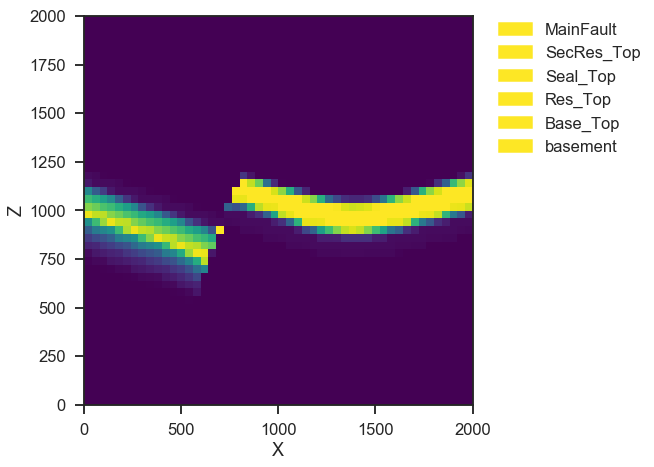

In [55]:
import matplotlib
l = 2
norm = matplotlib.colors.Normalize(lith_prob[l].min(), lith_prob[l].max())
gp.plotting.plot_section(geo_data, lith_prob[l], cell_number=25, cmap='viridis',
                                     norm=norm)

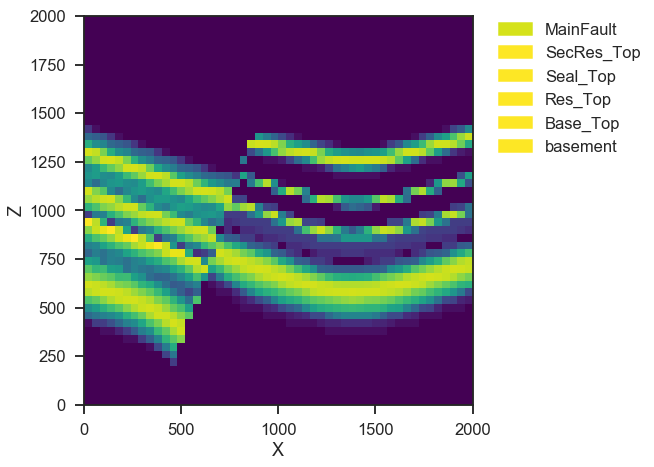

In [56]:
norm = matplotlib.colors.Normalize(lb_ie.min(), lb_ie.max())
gp.plotting.plot_section(geo_data, lb_ie, cell_number=25, cmap='viridis',
                                     norm=norm)

# POST ANALYSIS

In [57]:
from gempy import posterior_analysis_elisa as pa

In [58]:
post = pa.Posterior(dbname, interpdata=interp_data, entropy=False, geodata=geo_data)

In [59]:
vol_trace = post.db.trap_analysis[:][:,0]
ssf_trace = post.db.trap_analysis[:][:,1]
trap_control_trace = post.db.trap_analysis[:][:,2]

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

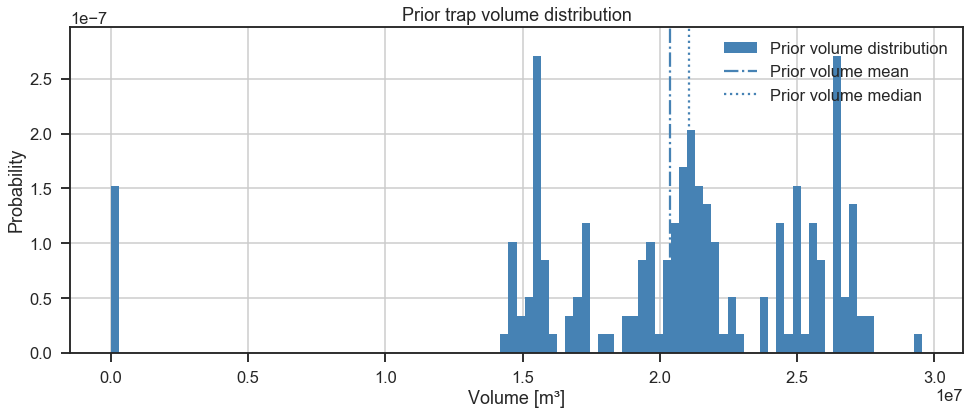

In [60]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(vol_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(vol_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(vol_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [61]:
#post = pa.Posterior(dbname, interpdata=interp_data, entropy=True, geodata=geo_data)

In [62]:
#post.i_need_this()
#post.get_points()

In [63]:
#ie = post.lb_ie

In [64]:
#post.calculate_ie_total(ie)

In [65]:
#post.plot_section_ie(plot_all_data=False)

In [66]:
#post.plot_section(1,fault=False)

In [67]:
# COUNT TRAP CONTROL OCCURRENCES
uniques, counts = np.unique(trap_control_trace, return_counts=True)
counts = np.round((counts/iterations)*100)

labels = ('UNCLEAR', 'SPILL POINT', 'LEAK UNDER', 'LEAK OVER', 'STRAT')
trap_base = dict(zip(labels, [0,0,0,0,0]))
trap_controls = dict(zip(labels, counts))

In [68]:
print(uniques, counts)

[1. 3.] [96.  4.]


In [69]:
vol_trace

array([       0., 25856000., 25856000., 22400000., 20352000.,        0.,
              0.,  2496000.,  3840000.,   448000.,   448000.,       nan,
        2944000.,        0.,        0.,  2944000.,    64000.,        0.,
              0.,   128000., 25088000., 25088000., 24832000., 24832000.,
       24832000., 24000000., 23936000.,        0.,        0.,   128000.,
        6848000.,  7168000.,  4544000.,  4160000.,   960000.,   128000.,
       10944000., 11008000., 10944000.,  9856000.,  3712000.,  9792000.,
        3648000., 24576000., 24576000.,        0., 22720000., 22720000.,
       22016000., 22016000.,        0.,        0.,        0., 24896000.,
        1088000., 21824000., 20672000., 15616000.,   192000., 28160000.,
       28288000., 26240000., 23744000., 23616000., 23488000., 25856000.,
              0.,    64000.,  8512000.,   128000.,  8512000.,  8512000.,
              0.,        0., 21504000., 21504000., 21248000., 20864000.,
       20928000., 21312000., 21248000., 21888000., 

In [70]:
post._change_input_data(0)
interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
lith_block, fault_block = gp.compute_model(interp_data)

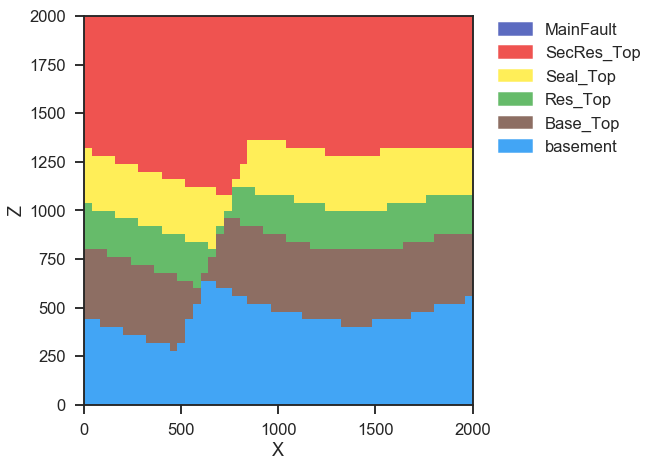

In [71]:
gp.plotting.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)

SPILL POINT COORDINATES: [1320.          840.          774.72999573]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 120.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 25
Maximum trap volume: 19200000.0 m³
TRAP VOXELS: 300


(19200000.0, 4.0, 1)

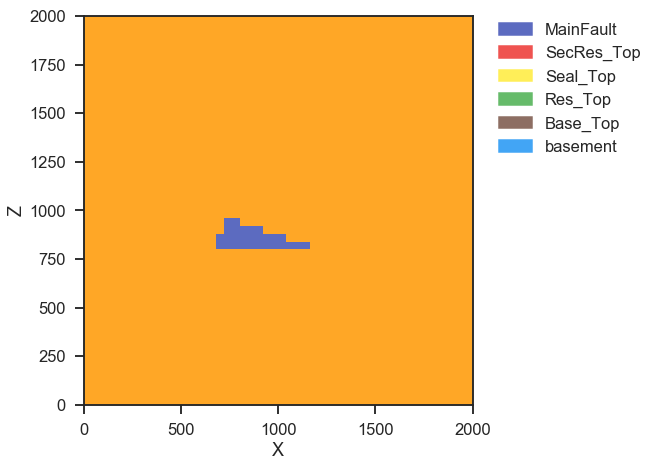

In [78]:
trap_analysis_post(lith_block, fault_block, print_figures=True)

In [67]:
#vol, SSF, tc = [],[],[]
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    #gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, plot_data=True)
#    v,s,c = trap_analysis_post(lith_sol, fault_sol, print_figures=True)
#    vol.append(v)
#    SSF.append(s)
#    tc.append(c)

In [68]:
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    gp.plotting.plot_section(interp_data.geo_data_res, lith_sol[0], 25, plot_data=True)

In [ ]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()